In [21]:
# CLAIM: The model recovers more spurious ORFs than HMM-based tools 

In [22]:
import pandas as pd
from utils import *  
import os 
import numpy as np 
from scipy.stats.contingency import expected_freq
import re
from src.reference import annotate
from src.files import BLASTJsonFile
import seaborn as sns
from scipy.stats import chisquare
import glob
from matplotlib.lines import Line2D

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def write_csv(df:pd.DataFrame, path:str=None):
    df = df.copy()
    
    is_overlap_at_query_n_terminus = lambda row : ((row.query_strand == 1) and (row.query_overlap == '10')) or ((row.query_strand == -1) and (row.query_overlap == '01'))
    is_overlap_at_top_hit_n_terminus = lambda row : ((row.top_hit_strand == 1) and (row.top_hit_overlap == '10')) or ((row.top_hit_strand == -1) and (row.top_hit_overlap == '01'))

    df['query_overlap_at_n_terminus'] = df.apply(is_overlap_at_query_n_terminus, axis=1)
    df['top_hit_overlap_at_n_terminus'] = df.apply(is_overlap_at_top_hit_n_terminus, axis=1)
    columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'query_overlap_at_n_terminus', 'length', 'top_hit_length', 'overlap_length', 'top_hit_spurious', 'query_rbs_motif']
    df[columns].to_csv(path)
    print(f'write_csv: Wrote {len(df)} sequences to {path}.')

In [24]:
dataset_path = '../data/results/results-2/dataset.csv'
top_hit_predictions_path = '../data/results/results-2/top_hits_predict.csv'
predictions_path = '../data/results/results-2/dataset_predict.csv'

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 

results_df = load_results(dataset_path=dataset_path, top_hit_predictions_path=top_hit_predictions_path, predictions_path=predictions_path, exclude_genome_ids=exclude_genome_ids)

In [25]:
# All but 4 of the non-coding conflicts are predicted to be spurious. What are the characteristics of the ones which are predicted to be real with high confidence?
for row in results_df[is_non_coding_conflict(results_df) & (results_df.real)].itertuples():
    print(row.Index, f'{row.model_label}, {row.model_output_1 * 100:.2f}% confidence')
    print(f'top_hit_feature: {row.top_hit_feature}')
    print(f'top_hit_note: {row.top_hit_note}')
    print('same_strand:', row.same_strand, 'query_strand:', row.query_strand)
    print('overlap_length:', row.overlap_length, f'{row.query_overlap_fraction * 100:.2f}% of query')
    print(f'genome: {row.genome_id}, on contig {row.top_hit_contig_id}, ({row.query_start}, {row.query_stop})')
    print()

NZ_JAIKTU010000008.1_127 real, 100.00% confidence
top_hit_feature: CDS
top_hit_note: incomplete; partial in the middle of a contig; missing N-terminus; Derived by automated computational analysis using gene prediction method: Protein Homology.
same_strand: False query_strand: 1
overlap_length: 228 13.64% of query
genome: GCF_019753795.1, on contig NZ_JAIKTU010000008, (150850, 152520)

NZ_QXIU01000029.1_3 real, 95.94% confidence
top_hit_feature: CDS
top_hit_note: incomplete; partial in the middle of a contig; missing C-terminus; Derived by automated computational analysis using gene prediction method: Protein Homology.
same_strand: False query_strand: 1
overlap_length: 439 85.08% of query
genome: GCF_003570935.1, on contig NZ_QXIU01000029, (1014, 1529)

NZ_CP018099.1_801 real, 100.00% confidence
top_hit_feature: rRNA
top_hit_note: Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: 1
overlap_length: 363 100.00% of query
gen

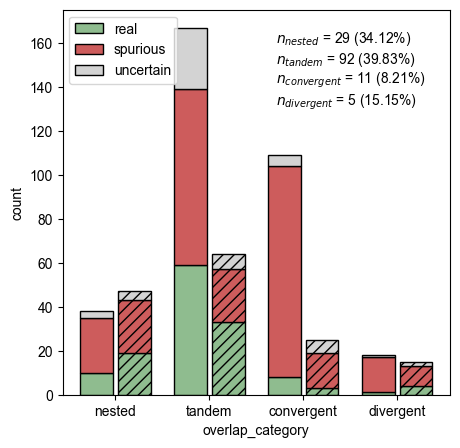

In [ ]:
# TODO: Flip this so that the hatches are stacked. 

def figure(results_df:pd.DataFrame, model_label:str='real'):
    figure_df = results_df[is_cds_conflict(results_df)].copy()
    figure_df['top_hit_hypothetical'] = is_top_hit_hypothetical(figure_df)

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for model_label, df in ax_df.groupby('model_label'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=model_label if add_label else '', color=palette[model_label], width=width - 0.05, hatch=hatch, )
            bottom += np.array(heights)
            totals += heights
     
    panel_a(figure_df[~figure_df.top_hit_hypothetical], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_hypothetical], offset=width/2, hatch='///', add_label=False)
    ax.set_xticks(positions, labels=overlap_types)
    ax.set_ylabel('count')
    ax.set_xlabel('overlap_category')
    ax.legend(loc='upper left')

    text = ''
    for category in ['nested', 'tandem', 'convergent', 'divergent']:
        text += get_text(category, ((figure_df.overlap_type == category) & (figure_df[model_label])).sum(), (figure_df.overlap_type == category).sum())
    ax.text(0.55, 0.7, text, transform=ax.transAxes)

    plt.show()


figure(results_df)

In [27]:
print('Num. conflicts where both top hit and Prodigal prediction are classified as real:')
for overlap_type in ['tandem', 'divergent', 'convergent', 'nested']:
    n = (is_cds_conflict(results_df) & results_df.top_hit_real & results_df.real & (results_df.overlap_type == overlap_type)).sum()
    print('\t', overlap_type, n)

Num. conflicts where both top hit and Prodigal prediction are classified as real:
	 tandem 87
	 divergent 3
	 convergent 9
	 nested 9


In [28]:
# Might be good to take a closer look at the antiparallel-conflicting proteins predicted to be real with high confidence.
# There are too many spurious predictions to look at in any depth. 

df = results_df[is_antiparallel_cds_conflict(results_df) & results_df.real].copy()

n_hypothetical = (df.top_hit_product != 'hypothetical protein').sum()
n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')).sum()

print('Num. real-predicted antiparallel conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, len(df))})')
print('Num. real-predicted antiparallel conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, len(df))})', end='\n\n')

for overlap_type in ['divergent', 'convergent']:
    n_hypothetical = ((df.top_hit_product != 'hypothetical protein') & (df.overlap_type == overlap_type)).sum()
    n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction') & (df.overlap_type == overlap_type)).sum()

    print(f'Num. real-predicted {overlap_type} conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, (df.overlap_type == overlap_type).sum())})')
    print(f'Num. real-predicted {overlap_type} conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, (df.overlap_type == overlap_type).sum())})', end='\n\n')

columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'phase', 'length', 'top_hit_length', 'overlap_length', 'spans_assembly_gap', 'overlap_type']
df['spans_assembly_gap'] = df.seq.str.count('X') > 2
df[columns].to_csv('../data/results/results-2/antiparallel_real.csv')

# Export the Prodigal-predicted and reference sequences for InterPro annotation and BLAST alignment.
write_fasta(df, path='../data/results/results-2/antiparallel_real.faa', add_top_hit=True)

# pd.crosstab(df.overlap_type, df.phase)

Num. real-predicted antiparallel conflicts with hypothetical proteins: 9 (56.25%)
Num. real-predicted antiparallel conflicts with unsupported proteins: 6 (37.50%)

Num. real-predicted divergent conflicts with hypothetical proteins: 1 (20.00%)
Num. real-predicted divergent conflicts with unsupported proteins: 4 (80.00%)

Num. real-predicted convergent conflicts with hypothetical proteins: 8 (72.73%)
Num. real-predicted convergent conflicts with unsupported proteins: 2 (18.18%)

write_fasta: Wrote 32 sequences to ../data/results/results-2/antiparallel_real.faa


In [29]:
# IDs from the tandem overlaps which are likely due to a fragmented protein; from results-2-2-si2.ipynb.
tandem_fragment_ids = ['NZ_JAALLS010000037.1_4', 'NZ_JAALLS010000005.1_1', 'NZ_CP063767.1_1564', 'NZ_JAYGHR010000002.1_180', 'NZ_JAYGHR010000010.1_46', 'NZ_JAYGHR010000095.1_4', 'NC_021487.1_586', 'NZ_JAIKTU010000005.1_51', 'NZ_QXIU01000121.1_2', 'NZ_QXIU01000013.1_4', 'NZ_QXIU01000201.1_20', 'NZ_QXIU01000258.1_3', 'NZ_QXIU01000037.1_8', 'NZ_QXIU01000048.1_21', 'NZ_QXIU01000073.1_4', 'NZ_QXIU01000088.1_2', 'NZ_CP018099.1_1950', 'NZ_AP025523.1_725', 'NZ_AP025523.1_1853', 'NZ_AP025523.1_2690', 'NZ_CP130454.1_336', 'NZ_CP130454.1_2358', 'NZ_CP130454.1_3138', 'NZ_CP130454.1_3168', 'NC_015499.1_1072', 'NZ_NIGF01000012.1_26', 'NZ_NIGF01000022.1_4', 'NC_014960.1_288', 'NC_014960.1_2737', 'NZ_AP035449.1_427', 'NZ_AP035449.1_1439']


figure: Num. real +1 overlaps: 0 (0.00%)
figure: Num. real +4 overlaps: 0 (0.00%)
figure: Num. real phase +1 overlaps: 2 (12.50%)
figure: Num. real phase +2 overlaps: 7 (43.75%)


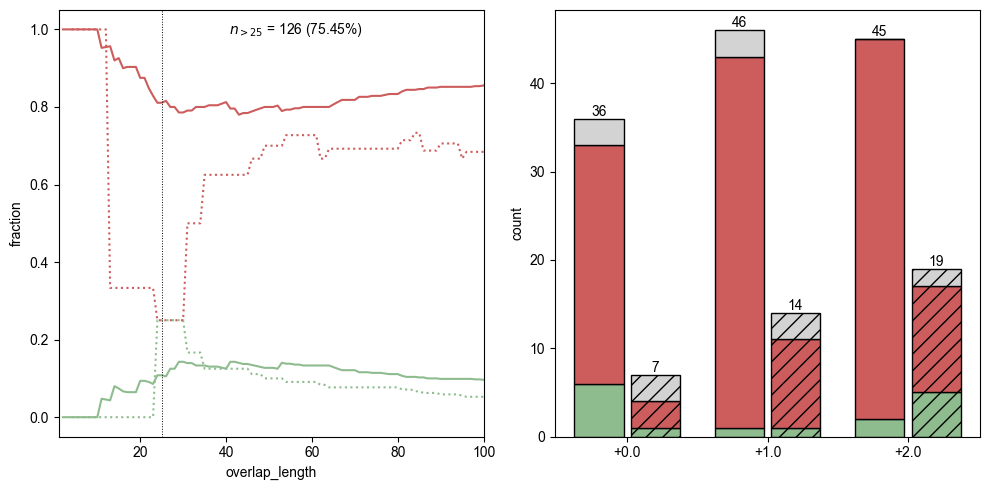

In [47]:
def si_figure(results_df:pd.DataFrame, overlap_type:str='antiparallel', width:float=0.4, overlap_length:int=30, exclude_ids:list=None):

    if overlap_type == 'antiparallel':
        figure_df = results_df[is_antiparallel_cds_conflict(results_df)].copy()
    else:
        figure_df = results_df[is_tandem_cds_conflict(results_df)].copy()
        figure_df = figure_df[figure_df.phase != 0].copy()

    if exclude_ids is not None:
        figure_df = figure_df[~figure_df.index.isin(exclude_ids)].copy()

    fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

    def panel_a(figure_df:pd.DataFrame, ax:plt.Axes=None, linestyle:str='-'):
        min_overlap_length = figure_df.overlap_length.min()
        overlap_lengths = np.arange(min_overlap_length, 400)

        ax_df = pd.DataFrame(index=overlap_lengths, columns=['uncertain', 'real', 'spurious', 'hypothetical'])
        ax_df['overlap_length'] = overlap_lengths

        for overlap_length in overlap_lengths:
            df = figure_df[figure_df.overlap_length <= overlap_length]
            ax_df.loc[overlap_length, 'spurious'] = df.spurious.sum() / len(df)
            ax_df.loc[overlap_length, 'real'] = df.real.sum() / len(df)
        sns.lineplot(data=ax_df[~ax_df.spurious.isnull()], x='overlap_length', y='spurious', color='indianred', ax=ax, linestyle=linestyle)
        sns.lineplot(data=ax_df[~ax_df.real.isnull()], x='overlap_length', y='real', color='darkseagreen', ax=ax, linestyle=linestyle)

        ax.set_ylabel('fraction')
        ax.set_xlim(xmax=100, xmin=1)

    def panel_b(ax_df:pd.DataFrame, ax=None, offset:float=None, hatch:str=None):
        phases = sorted(figure_df.phase.unique())
        # ax_df = ax_df[ax_df.overlap_length > 7]

        positions = np.arange(len(phases)) + offset
        totals = ax_df.groupby('phase').apply(len, include_groups=False).loc[phases]
        bottom = np.zeros(len(phases))

        for model_label, df in ax_df.groupby('model_label'):
            heights = np.array([(df.phase == phase).sum() for phase in phases])
            ax.bar(positions, heights, bottom=bottom, edgecolor='black', label=model_label, color=palette[model_label], hatch=hatch, width=width - 0.05)
            bottom += np.array(heights)

        for x, y in zip(positions, totals):
            ax.text(x, y, str(int(y)), ha='center', va='bottom')

        ax.set_xticks(np.arange(len(phases)), labels=[f'+{phase}' for phase in phases])
        ax.set_ylabel('count')
    
    panel_a(figure_df[~is_top_hit_hypothetical(figure_df)].copy(), ax=ax_a)
    panel_a(figure_df[is_top_hit_hypothetical(figure_df)], ax=ax_a, linestyle=':')

    ax_a.text(0.4, 0.9, get_text(f'>{overlap_length}', (figure_df.overlap_length > overlap_length).sum(), len(figure_df)), transform=ax_a.transAxes)
    ax_a.axvline(overlap_length, ls=':', lw=0.7, color='black')

    panel_b(figure_df[is_top_hit_hypothetical(figure_df)], ax=ax_b, offset=width/2, hatch='//')
    panel_b(figure_df[~is_top_hit_hypothetical(figure_df)], ax=ax_b, offset=-width/2)

    figure_df = figure_df[figure_df.real].copy()
    print('figure: Num. real +1 overlaps:', (figure_df.overlap_length == 1).sum(), f'({get_percent((figure_df.overlap_length == 1).sum(), len(figure_df))})')
    print('figure: Num. real +4 overlaps:', (figure_df.overlap_length == 4).sum(), f'({get_percent((figure_df.overlap_length == 4).sum(), len(figure_df))})')
    print('figure: Num. real phase +1 overlaps:', (figure_df.phase == 1).sum(), f'({get_percent((figure_df.phase == 1).sum(), len(figure_df))})')
    print('figure: Num. real phase +2 overlaps:', (figure_df.phase == 2).sum(), f'({get_percent((figure_df.phase == 2).sum(), len(figure_df))})')

    fig.tight_layout()
    plt.show()

# si_figure(results_df, overlap_length=25)
si_figure(results_df, overlap_length=25, overlap_type='antiparallel', exclude_ids=tandem_fragment_ids)


In [31]:
model_label = 'real'

# Export the Prodigal-predicted and reference sequences for InterPro annotation and BLAST alignment.
write_fasta(results_df[is_tandem_cds_conflict(results_df) & (results_df.overlap_length > 60) & results_df[model_label]], path=f'../data/results/results-2/tandem_{model_label}.faa', add_top_hit=True)
write_csv(results_df[is_tandem_cds_conflict(results_df) & (results_df.overlap_length > 60) & results_df[model_label]], path=f'../data/results/results-2/tandem_{model_label}.csv')

write_fasta: Wrote 26 sequences to ../data/results/results-2/tandem_real.faa
write_csv: Wrote 13 sequences to ../data/results/results-2/tandem_real.csv.


In [35]:
def print_nested_results(results_df):
    results_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'nested')].copy()
    results_df['query_nested'] = results_df.query_length < results_df.top_hit_length
    
    df = pd.DataFrame(index=results_df.index)

    fields = [col.replace('query_', '') for col in results_df.columns if (('query' in col) and (col != 'query_nested'))]
    fields = np.intersect1d([col.replace('top_hit_', '') for col in results_df.columns if ('top_hit' in col)], fields)

    for field in fields:
        df[f'parent_{field}'] = np.where(results_df.query_nested, results_df[f'top_hit_{field}'], results_df[f'query_{field}'])
        df[f'daughter_{field}'] = np.where(results_df.query_nested, results_df[f'query_{field}'], results_df[f'top_hit_{field}'])
    df['overlap_length'] = results_df.overlap_length
    df['same_strand'] = results_df.same_strand

    print('print_nested_results: Num. nested conflicts:', len(df))
    print('print_nested_results: Num. parent and daughter spurious:', (df.daughter_spurious & df.parent_spurious).sum())
    print('print_nested_results: Num. parent and daughter real:', (df.daughter_real & df.parent_real).sum())
    print('print_nested_results: Num. parent real and daughter spurious:', (df.daughter_spurious & df.parent_real).sum())
    print('print_nested_results: Num. parent spurious daughter real:', (df.daughter_real & df.parent_spurious).sum())


print_nested_results(results_df)


print_nested_results: Num. nested conflicts: 85
print_nested_results: Num. parent and daughter spurious: 13
print_nested_results: Num. parent and daughter real: 9
print_nested_results: Num. parent real and daughter spurious: 33
print_nested_results: Num. parent spurious daughter real: 14


In [41]:
adjusted_dataset_path = '../data/results/results-2/adjusted_conflict.csv'
adjusted_predictions_path = '../data/results/results-2/adjusted_conflict_predict.csv'

adjusted_results_df = load_results(dataset_path=adjusted_dataset_path, predictions_path=adjusted_predictions_path, annotate=False)

product_map = {id_:product for id_, product in zip(results_df.top_hit_protein_id, results_df.top_hit_product) if (id_[0] == 'W')}
product_map.update({id_:'hypothetical_protein' for id_ in results_df.index})

for field in ['model_output_1', 'model_output_0', 'model_label', 'seq']:
    map_ = {id_:df[df.truncation_length == 0][field].iloc[0] for id_, df in adjusted_results_df.groupby('id') if ((df.truncation_length == 0).sum() > 0)}
    adjusted_results_df[f'original_{field}'] = adjusted_results_df['id'].map(map_)

for field in ['model_output_1', 'model_output_0', 'model_label', 'seq']:
    map_ = {id_:df[df.truncation_length == 0][field].iloc[0] for id_, df in adjusted_results_df.groupby('id') if ((df.truncation_length == 0).sum() > 0)}
    adjusted_results_df[f'conflict_{field}'] = adjusted_results_df['conflict_id'].map(map_)

adjusted_results_df['conflict_product'] = adjusted_results_df['conflict_id'].map(product_map)
adjusted_results_df['product'] = adjusted_results_df['id'].map(product_map)


In [42]:
print('Num. adjusted proteins:', adjusted_results_df[adjusted_results_df.truncation_length > 0]['id'].nunique())
print('Num. resolvable conflicts:', adjusted_results_df[adjusted_results_df.overlap_length == 0]['pair_id'].nunique())

Num. adjusted proteins: 262
Num. resolvable conflicts: 186


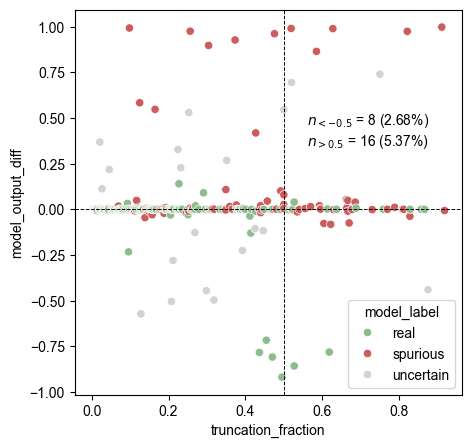

In [46]:
def figure(adjusted_results_df:pd.DataFrame, color_by:str='model_label'):

    fig, ax = plt.subplots(figsize=(5, 5))

    # If a real or spurious model label does not change, this implies < 0.1 difference in the model output. 

    figure_df = adjusted_results_df.copy()
    figure_df = figure_df[figure_df.truncation_length > 0].copy()
    figure_df['model_output_diff'] = figure_df.original_model_output_1 - figure_df.model_output_1 
    figure_df['truncation_fraction'] = figure_df.truncation_length / figure_df.original_seq.apply(len)
    figure_df = figure_df.sort_values('truncation_fraction')

    palettes = dict()
    palettes['model_label'] = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    palettes['overlap_type'] = 'Grays'
    sns.scatterplot(figure_df, x='truncation_fraction', y='model_output_diff', hue=color_by, palette=palettes[color_by])

    text = get_text('<-0.5', (figure_df.model_output_diff < -0.5).sum(), len(figure_df))
    text += get_text('>0.5', (figure_df.model_output_diff > 0.5).sum(), len(figure_df))
    ax.text(0.6, 0.6, text, transform=ax.transAxes)

    ax.axhline(0, ls='--', color='black', lw=0.7)
    ax.axvline(0.5, ls='--', color='black', lw=0.7)
    # sns.scatterplot(figure_df, x='model_output_1', y='original_model_output_1', hue='truncation_fraction', legend=False)
    plt.show()

figure(adjusted_results_df, color_by='model_label')